In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,10 #sets figure size
from keras.models import Sequential #defines a linear stack of layers for deep learning models
from keras.layers import LSTM,Dropout,Dense 
# LSTM = great for sequential data like stock prices
# Dropout = tool used to help prevent overfitting by randomly dropping connections in the neural network
# Dense = a fully connected layer

from sklearn.preprocessing import MinMaxScaler #normalisation technique

In [3]:
dataset=pd.read_csv("NSE-TATA-Global-Beverages-Limited.csv")
dataset.head() #returns first 5 rows of dataframe by default

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


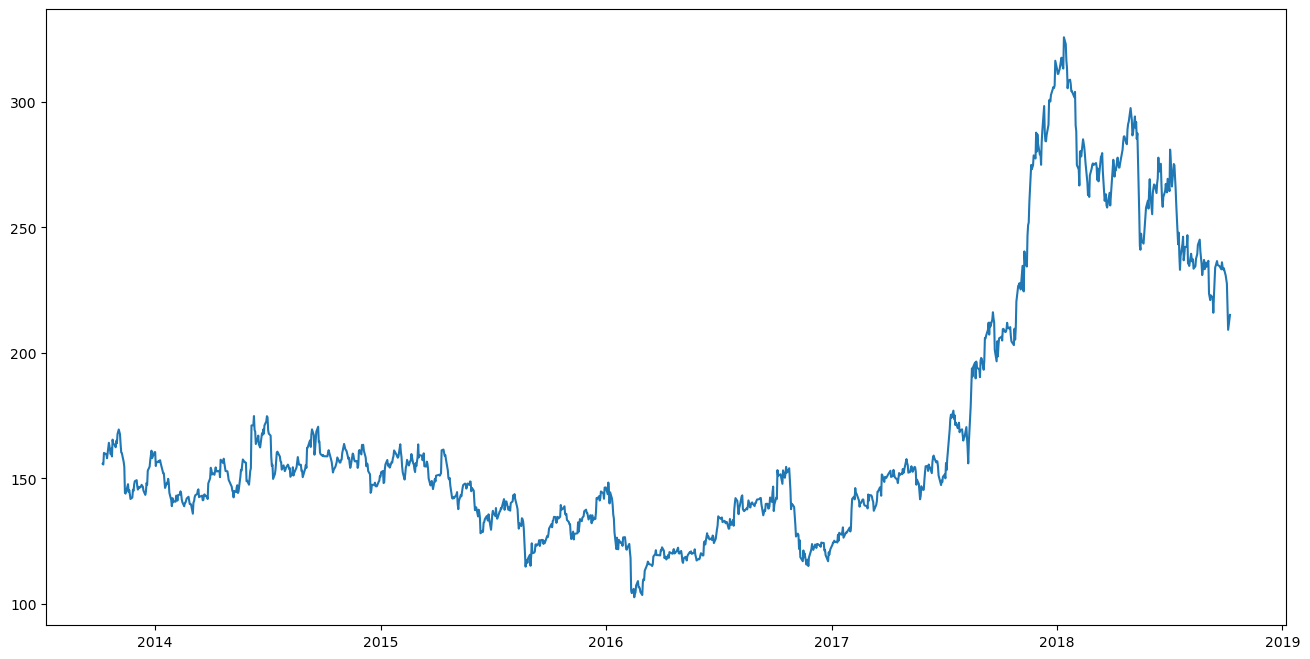

In [16]:
dataset["Date"]=pd.to_datetime(dataset.Date,format="%Y-%m-%d") #converts date column into python datetime objects 
dataset.index = dataset["Date"] #sets reference tag by data so not 0 1 2 3 but dates
dataset2 = dataset.sort_index()

plt.figure(figsize=(16,8))
plt.plot(dataset2["Close"],label="Close price history")
plt.show()


In [ ]:
data = dataset.sort_index(ascending=True,axis=0)  #sorts index in ascending order axis = 0 means sorting rows not column
new_dataset =pd.DataFrame(index=range(0,len(dataset)), columns = ['Date','Close']) #creates new dataframe rows from 0 to len of dataset with 2 columns date and close

for i in range(len(data)):
    new_dataset.loc[i, "Date"] = data.iloc[i]["Date"]
    new_dataset.loc[i, "Close"] = data.iloc[i]["Close"]


# for i in range(0,len(data)):
    #new_dataset["Date"][i]=data['Date'][i]
    #new_dataset["Close"][i]=data['Close'][i]




In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))